In [1]:
import sys
import os

import pandas as pd
import scanpy as sc
import numpy as np
import warnings

import torch
import torch.nn.functional as F
import torch.nn as nn
import scipy
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import DataParallel
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import anndata
import seaborn as sns
import matplotlib.font_manager
from matplotlib import rcParams
import scanpy as sc
font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'
rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

import sample_squidiff
from Squidiff.scrna_datasets import Drug_dose_encoder


In [2]:
test_adata = sc.read_h5ad('datasets/gears_test_data.h5ad')
train_adata = sc.read_h5ad('datasets/gears_train_data.h5ad')


In [3]:
train_adata

AnnData object with n_obs × n_vars = 7890 × 203
    obs: 'Group'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'neighbors', 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'pca', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
sampler = sample_squidiff.sampler(
        model_path = 'pertb_2genes/model.pt',
        gene_size = 203,
        output_dim = 203,
        use_drug_structure = False,
        
    )

load model and diffusion...
diffusion num of steps =  1000


In [5]:
z_sem_test = sampler.model.encoder(
        torch.tensor(test_adata.X.toarray()).to('cuda')
    )
z_sem_train = sampler.model.encoder(
        torch.tensor(train_adata.X.toarray()).to('cuda')
    )

In [6]:
z_sem_ctrl = z_sem_train[train_adata.obs['Group'] ==0].mean(axis=0)
z_sem_PTPN12 = z_sem_train[train_adata.obs['Group'] ==1].mean(axis=0)
z_sem_ZBTB25 = z_sem_train[train_adata.obs['Group'] ==2].mean(axis=0)

In [22]:
sample_comb= sampler.interp_with_direction(z_sem_origin = z_sem_ctrl,
                                       gene_size = 203,
                                       direction = z_sem_PTPN12 + z_sem_ZBTB25 - z_sem_ctrl,
                                       scale = 1,
                                       add_noise_term = False #add noise if for interpolation
                                      )

In [23]:
sample_comb.detach().cpu().numpy().mean(axis=0).min()

0.00042681873

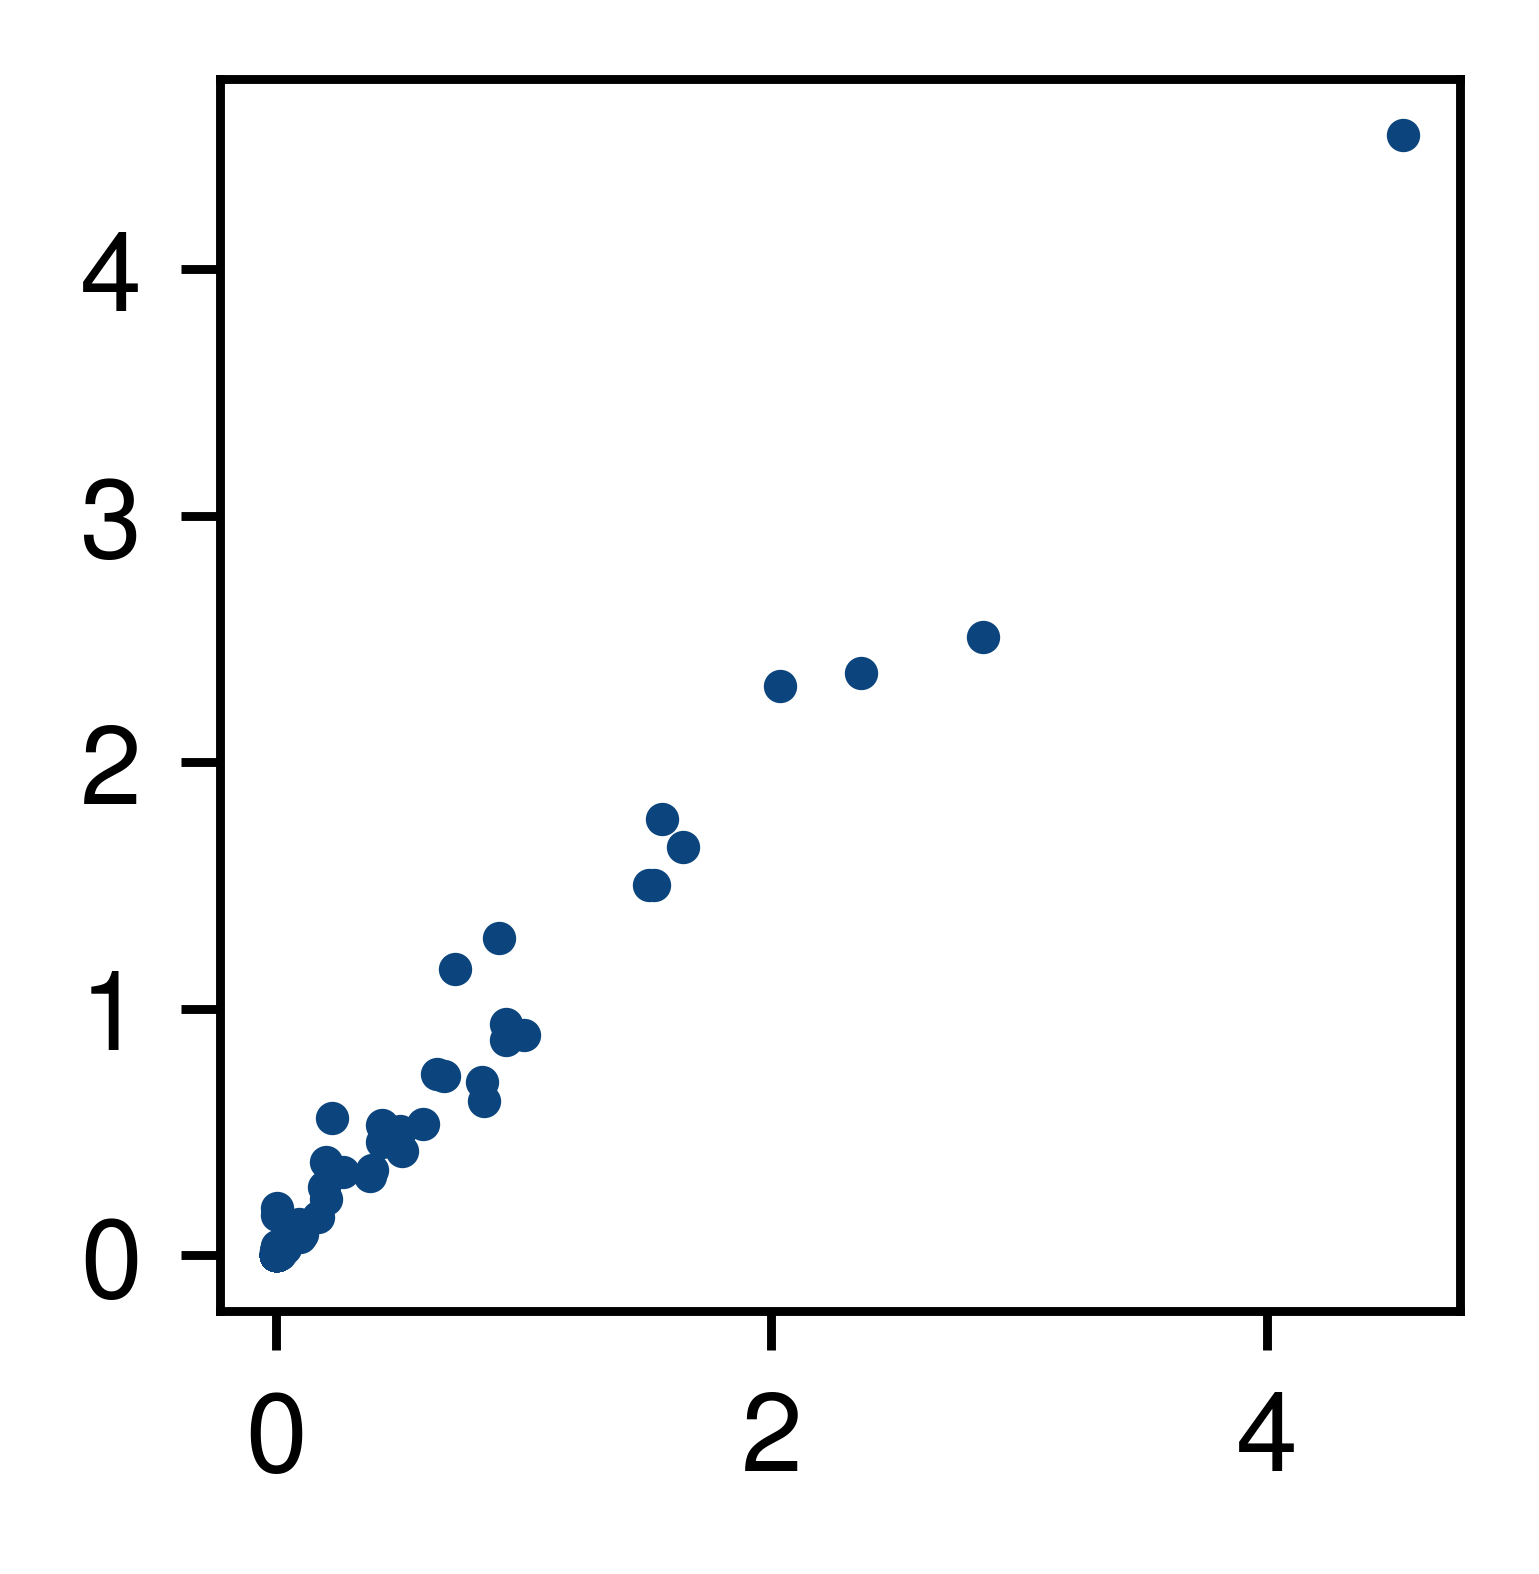

In [24]:
plt.subplots(1,1,figsize=(2,2),dpi=800)
plt.scatter(sample_comb.detach().cpu().numpy().mean(axis=0),
            np.array(test_adata[test_adata.obs['Group']==3].X.mean(axis=0)),
            s=4,
            c='#0c457d'
           )
#plt.xlim([0,4])
#plt.ylim([0,4])

In [25]:
import scipy
from sklearn.metrics import r2_score
p_ , _ = scipy.stats.pearsonr(
        np.array(test_adata[test_adata.obs['Group']==3].X.mean(axis=0)).transpose()[:,0],
        sample_comb.detach().cpu().numpy().mean(axis=0)
                    )

r_= r2_score(
        np.array(test_adata[test_adata.obs['Group']==3].X.mean(axis=0)).transpose(),
        sample_comb.detach().cpu().numpy().mean(axis=0)
                    )
print(p_)
print(r_)

0.9913951840014523
0.9826446175575256


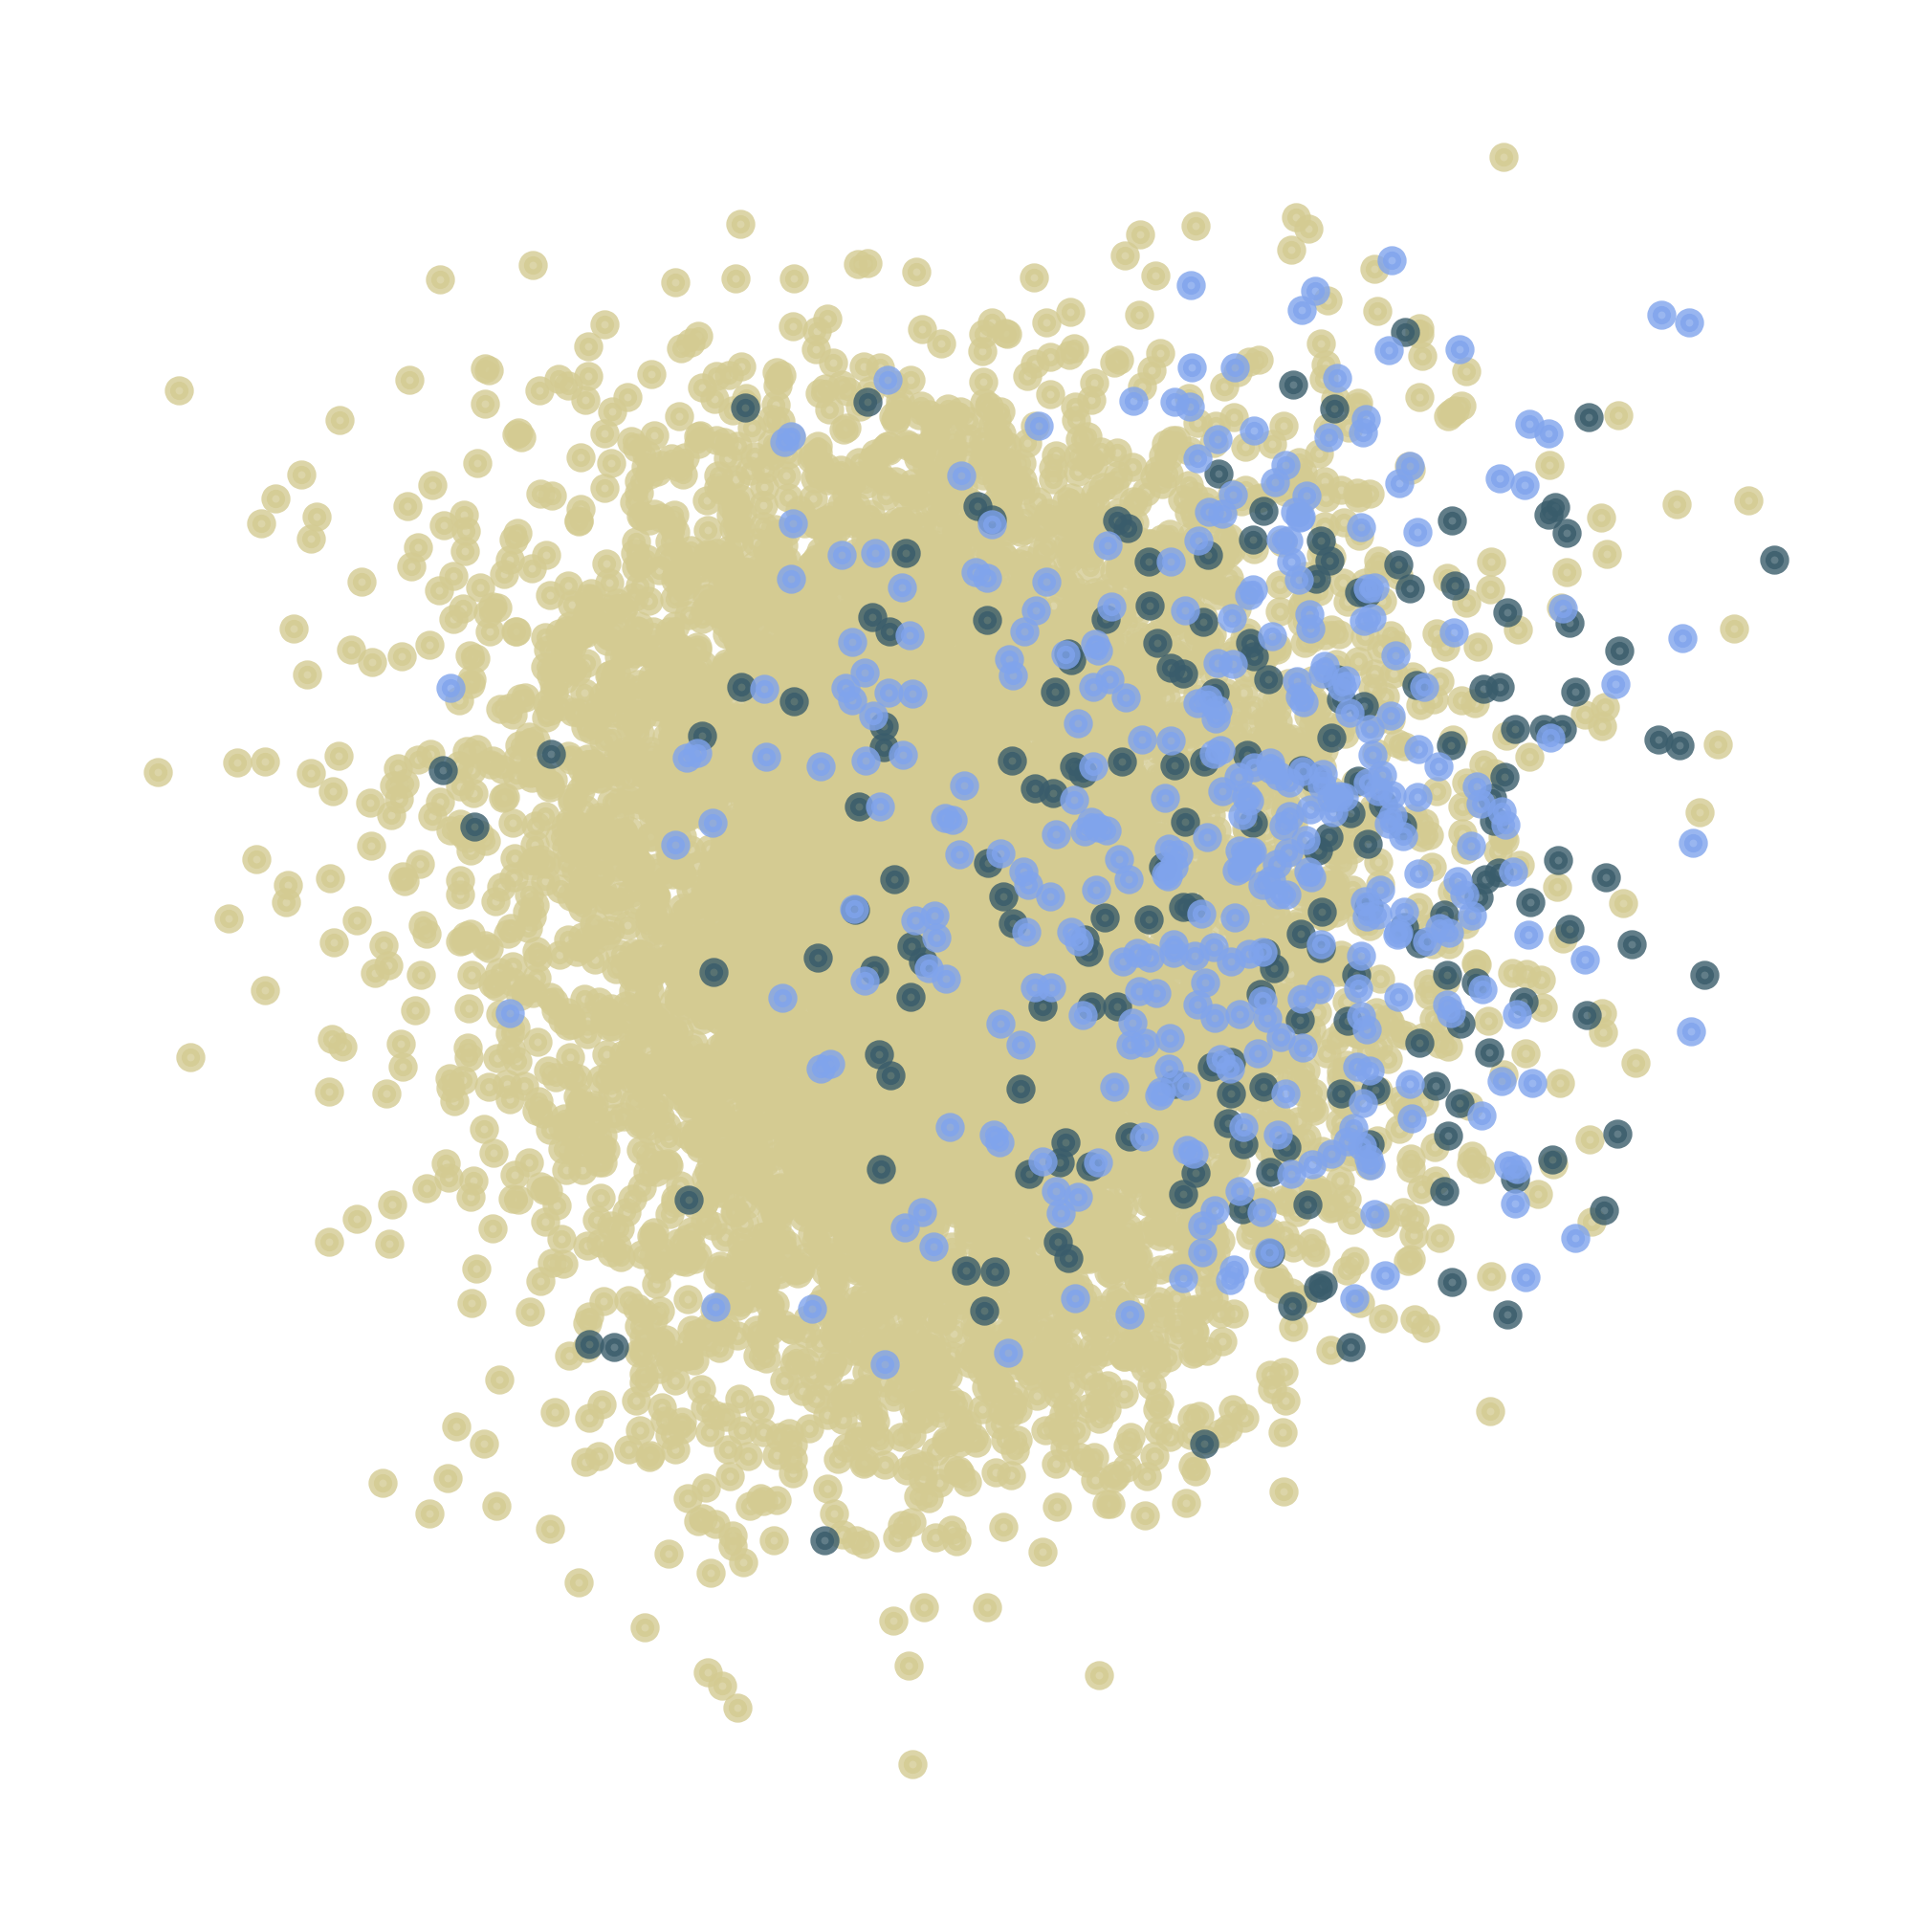

In [26]:
import plot_util
plot_util.plot_pca(z_sem_train,
                   label = train_adata.obs['Group'],
                   colorlist = ['#D4CB92', '#395C6B', '#80A4ED','#BCD3F2'],
                    color_label = [0,1,2,3],
                   size = 3, alpha=0.8)

In [27]:
from gears import PertData, GEARS
pert_data = PertData('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/perturb/data')
# load dataset in paper: norman, adamson, dixit.
pert_data.load(data_name = 'norman')
# specify data split
pert_data.prepare_split(split = 'simulation', seed = 1)
# get dataloader with batch size
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)
# set up and train a model
gears_model = GEARS(pert_data, device = 'cuda')
gears_model.model_initialize(hidden_size = 64)


Found local copy...
Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:43
combo_seen2:19
unseen_single:36
Done!
Creating dataloaders....
Done!
Creating dataloaders....
Done!


here1


Found local copy...


In [28]:
#gears_model.train(epochs = 20)

# save/load model
#gears_model.save_model('gears')
gears_model.load_pretrained('gears')

# predict
gears_model.predict([['PTPN12']])


{'PTPN12': array([ 2.6108789e-11,  6.7803517e-02,  1.1121240e-01, ...,
         3.2821100e+00,  1.8764349e-03, -4.5554573e-18], dtype=float32)}

In [29]:
import scgen
scgen.SCGEN.setup_anndata(train_adata, batch_key="Group")
scgen_model = scgen.SCGEN(train_adata)
scgen_model.save("scgen_model_perturb_prediction.pt", overwrite=True)
scgen_model.train(
    max_epochs=500,
    batch_size=16,
    early_stopping=True,
    early_stopping_patience=25
)
latent_X = scgen_model.get_latent_representation()



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 26/500:   5%|▌         | 26/500 [00:56<17:10,  2.17s/it, v_num=1, train_loss_step=1.24, train_loss_epoch=1.26]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 148.374. Signaling Trainer to stop.


In [30]:
z_sem_1 = latent_X[train_adata.obs['Group'] ==1].mean(axis=0)
z_sem_2 = latent_X[train_adata.obs['Group'] ==2].mean(axis=0)
z_sem_0 = latent_X[train_adata.obs['Group'] ==0].mean(axis=0)

interp_double = scgen_model.module.generative(torch.tensor(latent_X[train_adata.obs['Group'] ==0]+z_sem_2-z_sem_0+z_sem_1-z_sem_0))['px']
all_new_data_scgen3 = anndata.AnnData(interp_double.detach().cpu().numpy())
all_new_data_scgen3.var_names = train_adata.var['gene_name']

interp_double = scgen_model.module.generative(torch.tensor(latent_X[train_adata.obs['Group'] ==0]+z_sem_2-z_sem_0))['px']
all_new_data_scgen2 = anndata.AnnData(interp_double.detach().cpu().numpy())
all_new_data_scgen2.var_names = train_adata.var['gene_name']

In [31]:
# Simulate gene names and expression data
import random
np.random.seed(42)

temp_all= []
for i in range(10):
    temp_all.append(gears_model.predict([['PTPN12','ZBTB25']])['PTPN12_ZBTB25'][None,:])
all_new_data_gears3 = anndata.AnnData(np.concatenate(temp_all))
all_new_data_gears3.var_names = sc.read_h5ad('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/perturb/data/norman/perturb_processed.h5ad').var['gene_name']


temp_all= []
for i in range(10):
    temp_all.append(gears_model.predict([['ZBTB25']])['ZBTB25'][None,:])
all_new_data_gears2 = anndata.AnnData(np.concatenate(temp_all))
all_new_data_gears2.var_names = sc.read_h5ad('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/perturb/data/norman/perturb_processed.h5ad').var['gene_name']


all_new_data_3 = anndata.AnnData(sample_comb.detach().cpu().numpy())
all_new_data_3.var_names = train_adata.var['gene_name']


all_new_data_ctrl3 = test_adata[test_adata.obs['Group']==3].copy()
all_new_data_ctrl3.var_names = all_new_data_ctrl3.var['gene_name']

all_new_data_ctrl2 = train_adata[train_adata.obs['Group']==2].copy()
all_new_data_ctrl2.var_names = all_new_data_ctrl2.var['gene_name']

mean_expression_ctrl3 = all_new_data_ctrl3.to_df().mean(axis=0)


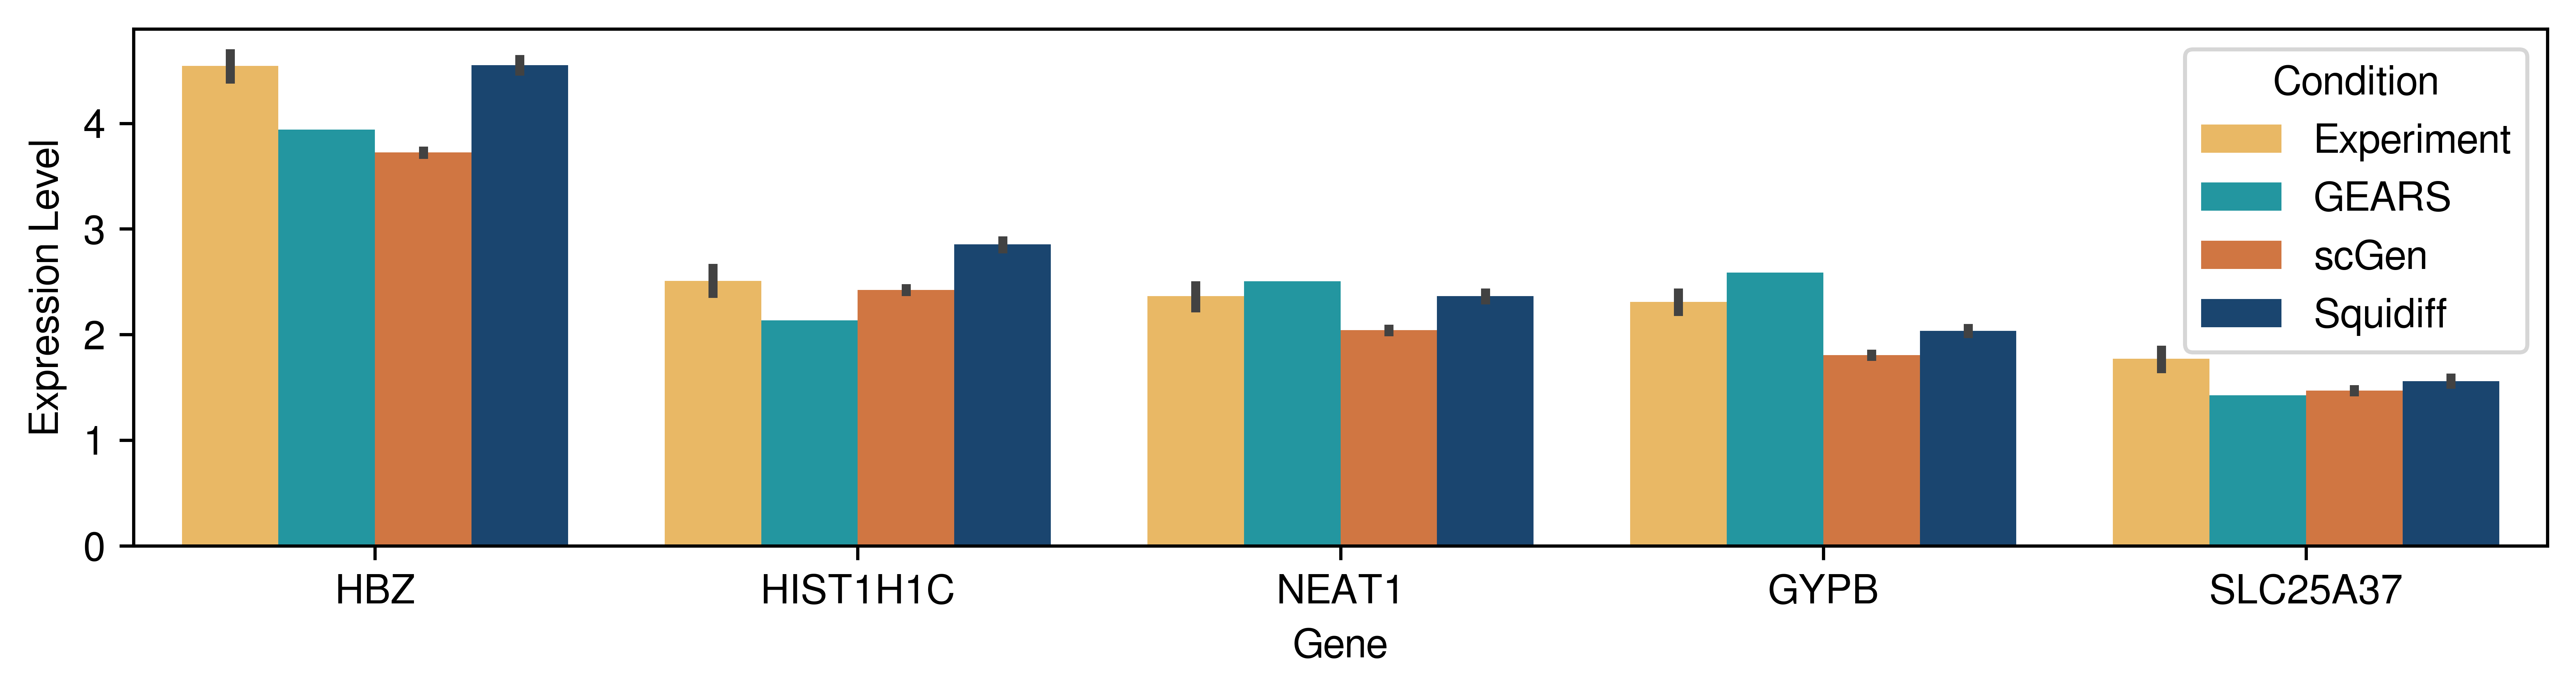

In [32]:
from scipy.stats import f_oneway
# Step 2: Find the gene names sorted from lowest to highest mean expression
sorted_genes = mean_expression_ctrl3.nlargest(203).index.tolist()

# Step 3: Randomly select 10 genes from the lowest-expressing genes
#genes_of_interest = random.sample(sorted_genes, 10)
genes_of_interest = []
for i in [0,1,2,3,4]:
    genes_of_interest.append(sorted_genes[i])
# Create DataFrames for each condition
df_data = all_new_data_3.to_df()[genes_of_interest]
df_data_ctrl = all_new_data_ctrl3.to_df()[genes_of_interest]
df_data_gears = all_new_data_gears3.to_df()[genes_of_interest]
df_data_scgen = all_new_data_scgen3.to_df()[genes_of_interest]

# Label each DataFrame with the corresponding condition
df_data_ctrl['Condition'] = 'Experiment'
df_data_gears['Condition'] = 'GEARS'
df_data_scgen['Condition'] = 'scGen'
df_data['Condition'] = 'Squidiff'

# Concatenate into a single DataFrame
df_combined = pd.concat([df_data_ctrl, df_data_gears, df_data_scgen, df_data], axis=0).reset_index(drop=True)

# Melt the DataFrame for seaborn
df_long = pd.melt(df_combined, id_vars=['Condition'], var_name='Gene', value_name='Expression')

# Set color palette
cmap = ['#ffbe4f', '#0ea7b5', '#e8702a', '#0c457d']

# Calculate p-values for each gene using ANOVA
p_values = {}
for gene in genes_of_interest:
    # Select data per gene grouped by condition
    groups = [df_combined[df_combined['Condition'] == condition][gene] for condition in df_combined['Condition'].unique()]
    # Perform ANOVA
    p_values[gene] = f_oneway(*groups).pvalue

# Now create the bar plot with ANOVA p-values annotated
plt.figure(figsize=(9, 2.5),dpi=800)
sns.barplot(data=df_long, x='Gene', y='Expression', hue='Condition', palette=cmap)
plt.ylabel('Expression Level')
plt.xlabel('Gene')

# Show the plot
plt.tight_layout()
plt.show()


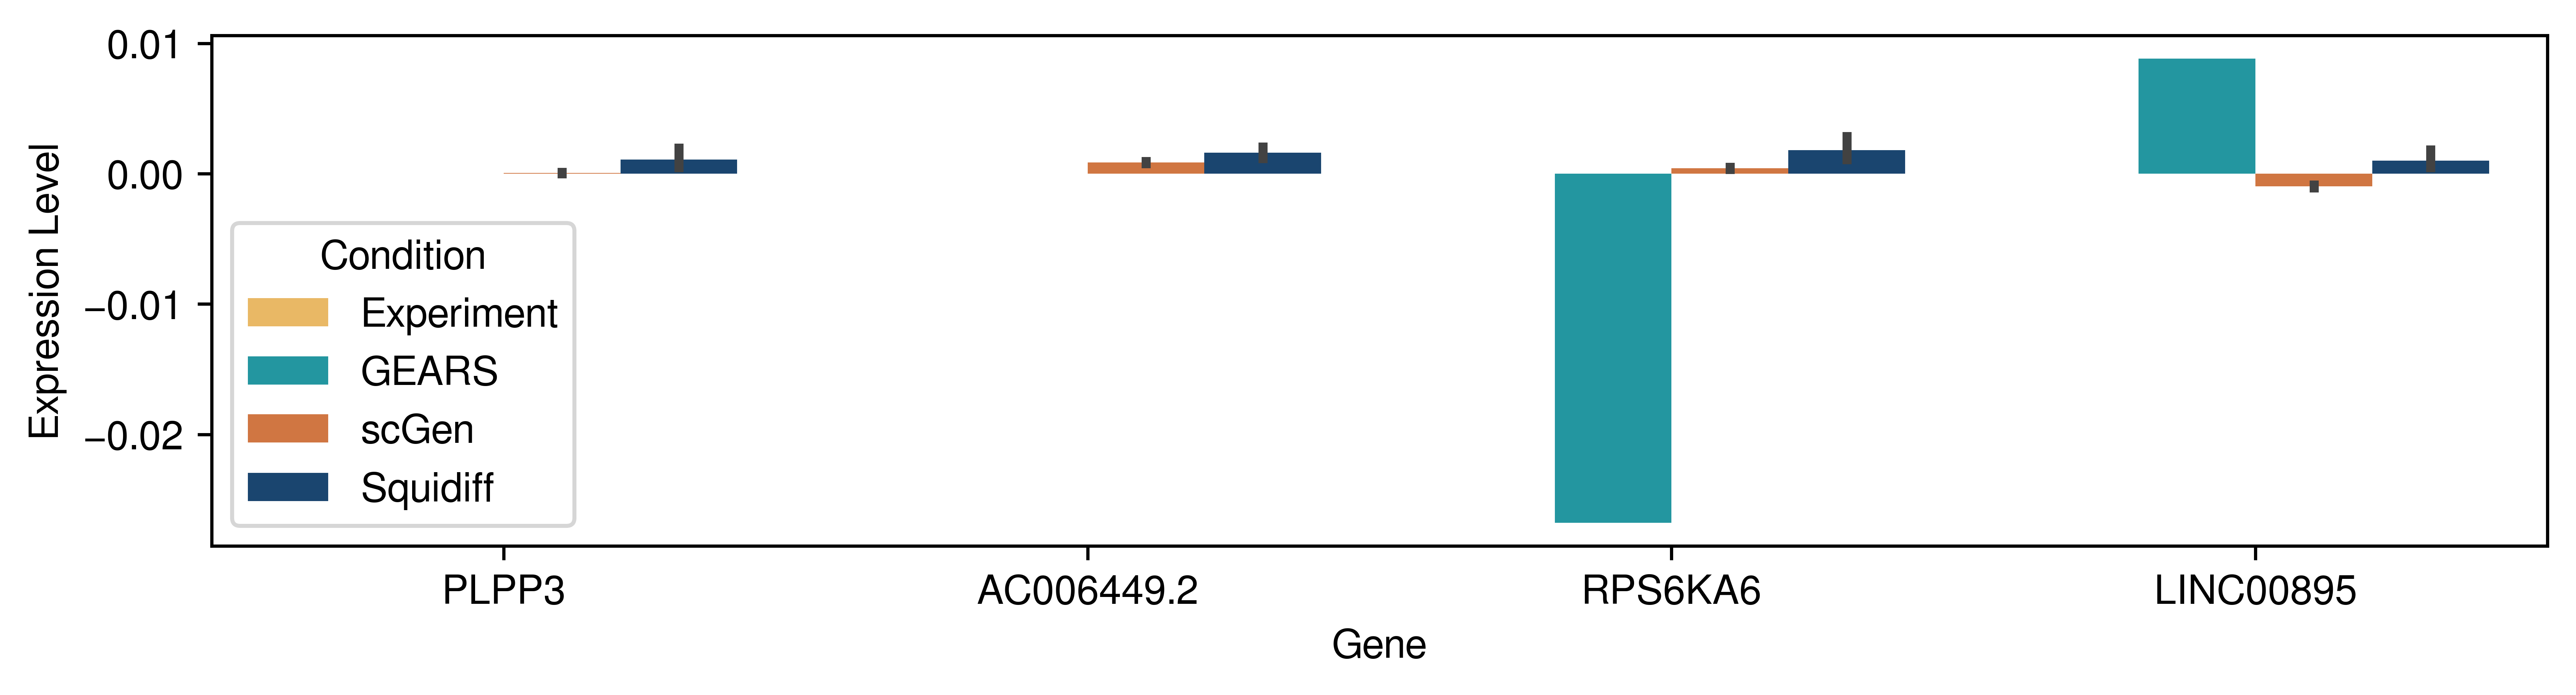

In [33]:
from scipy.stats import f_oneway
# Step 2: Find the gene names sorted from lowest to highest mean expression
sorted_genes = mean_expression_ctrl3.nlargest(203).index.tolist()

# Step 3: Randomly select 10 genes from the lowest-expressing genes
#genes_of_interest = random.sample(sorted_genes, 10)
genes_of_interest = []
for i in [120,130,150,160]:
    genes_of_interest.append(sorted_genes[i])
# Create DataFrames for each condition
df_data = all_new_data_3.to_df()[genes_of_interest]
df_data_ctrl = all_new_data_ctrl3.to_df()[genes_of_interest]
df_data_gears = all_new_data_gears3.to_df()[genes_of_interest]
df_data_scgen = all_new_data_scgen3.to_df()[genes_of_interest]

# Label each DataFrame with the corresponding condition
df_data_ctrl['Condition'] = 'Experiment'
df_data_gears['Condition'] = 'GEARS'
df_data_scgen['Condition'] = 'scGen'
df_data['Condition'] = 'Squidiff'

# Concatenate into a single DataFrame
df_combined = pd.concat([df_data_ctrl, df_data_gears, df_data_scgen, df_data], axis=0).reset_index(drop=True)

# Melt the DataFrame for seaborn
df_long = pd.melt(df_combined, id_vars=['Condition'], var_name='Gene', value_name='Expression')

# Set color palette
cmap = ['#ffbe4f', '#0ea7b5', '#e8702a', '#0c457d']

# Calculate p-values for each gene using ANOVA
p_values = {}
for gene in genes_of_interest:
    # Select data per gene grouped by condition
    groups = [df_combined[df_combined['Condition'] == condition][gene] for condition in df_combined['Condition'].unique()]
    # Perform ANOVA
    p_values[gene] = f_oneway(*groups).pvalue

# Now create the bar plot with ANOVA p-values annotated
plt.figure(figsize=(9, 2.5),dpi=800)
sns.barplot(data=df_long, x='Gene', y='Expression', hue='Condition', palette=cmap)
plt.ylabel('Expression Level')
plt.xlabel('Gene')

# Show the plot
plt.tight_layout()
plt.show()

Pearson correlation: mean = 0.9911422176534954 , 95% CI = [0.98963857 0.99265231]
R-squared: mean = 0.981867253780365 , 95% CI = [0.9790046  0.98508915]
MMD: mean = 6.759166717529297e-06 , 95% CI = [4.50611115e-06 9.39071178e-06]
Pearson correlation (GEARS): mean = 0.9460910680233023 , 95% CI = [0.94423446 0.94820206]
R-squared (GEARS): mean = 0.8852765679359436 , 95% CI = [0.88150804 0.89010955]
MMD (GEARS): mean = 0.00022341012954711913 , 95% CI = [0.00020289 0.00024765]
Pearson correlation (scGen): mean = 0.9882709557602309 , 95% CI = [0.98599015 0.99011983]
R-squared (scGen): mean = 0.9372521221637726 , 95% CI = [0.92483695 0.94517139]
MMD (scGen): mean = 2.9397010803222656e-05 , 95% CI = [2.24173069e-05 3.61502171e-05]
t-statistic: -67.49177868773205
p-value: 4.212768144997579e-23
t-statistic: -85.3420228225615
p-value: 6.246390632913129e-25
t-statistic: 5.1608322248741825
p-value: 6.563482404965421e-05
t-statistic: -20.606521185703436
p-value: 5.747384421088131e-14
t-statistic: -

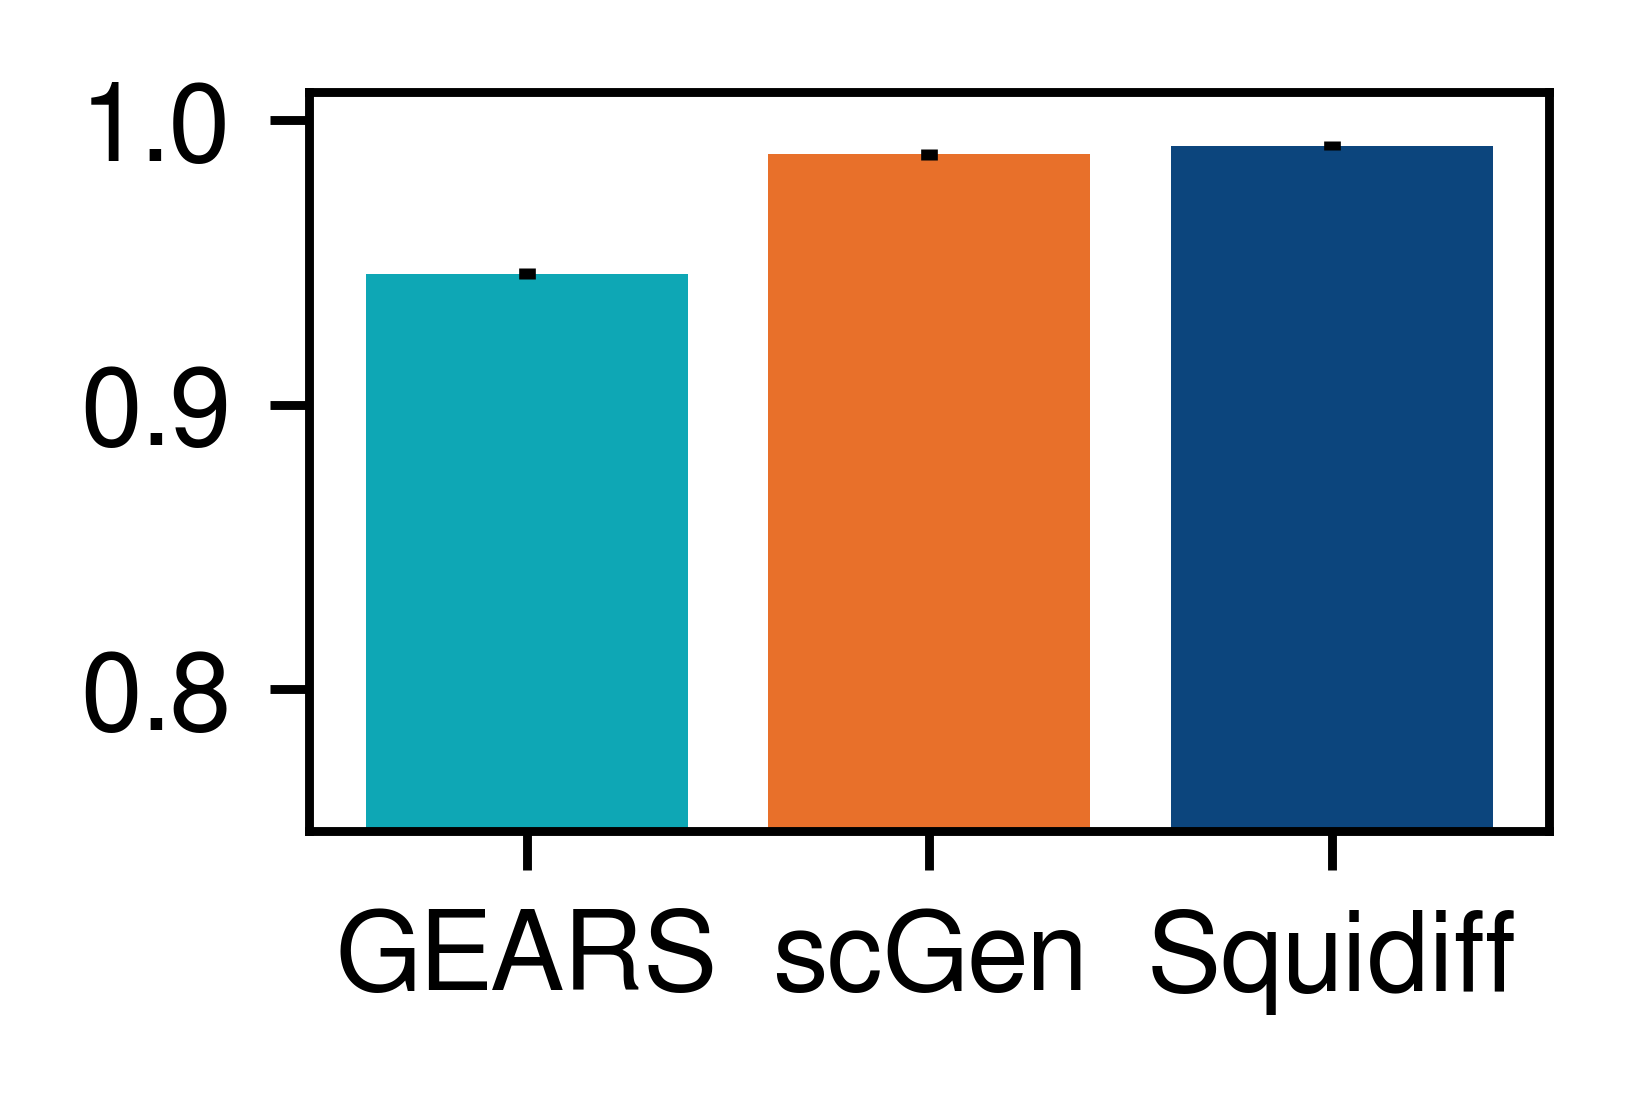

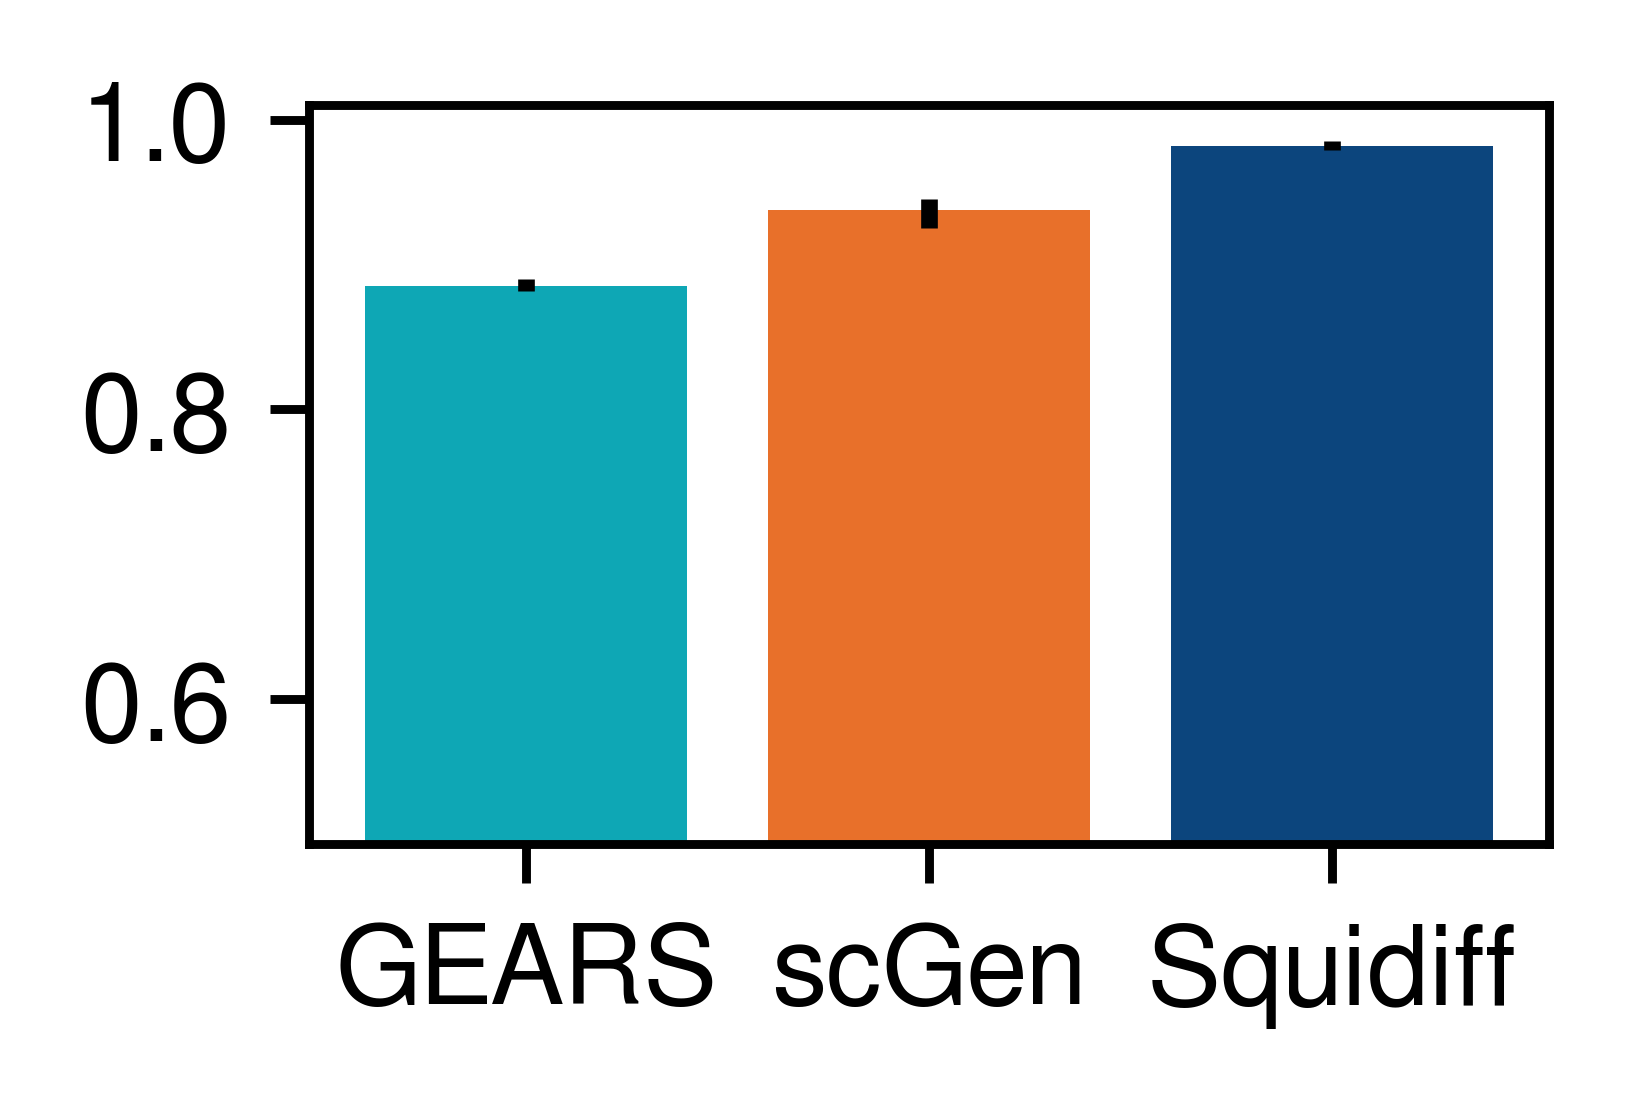

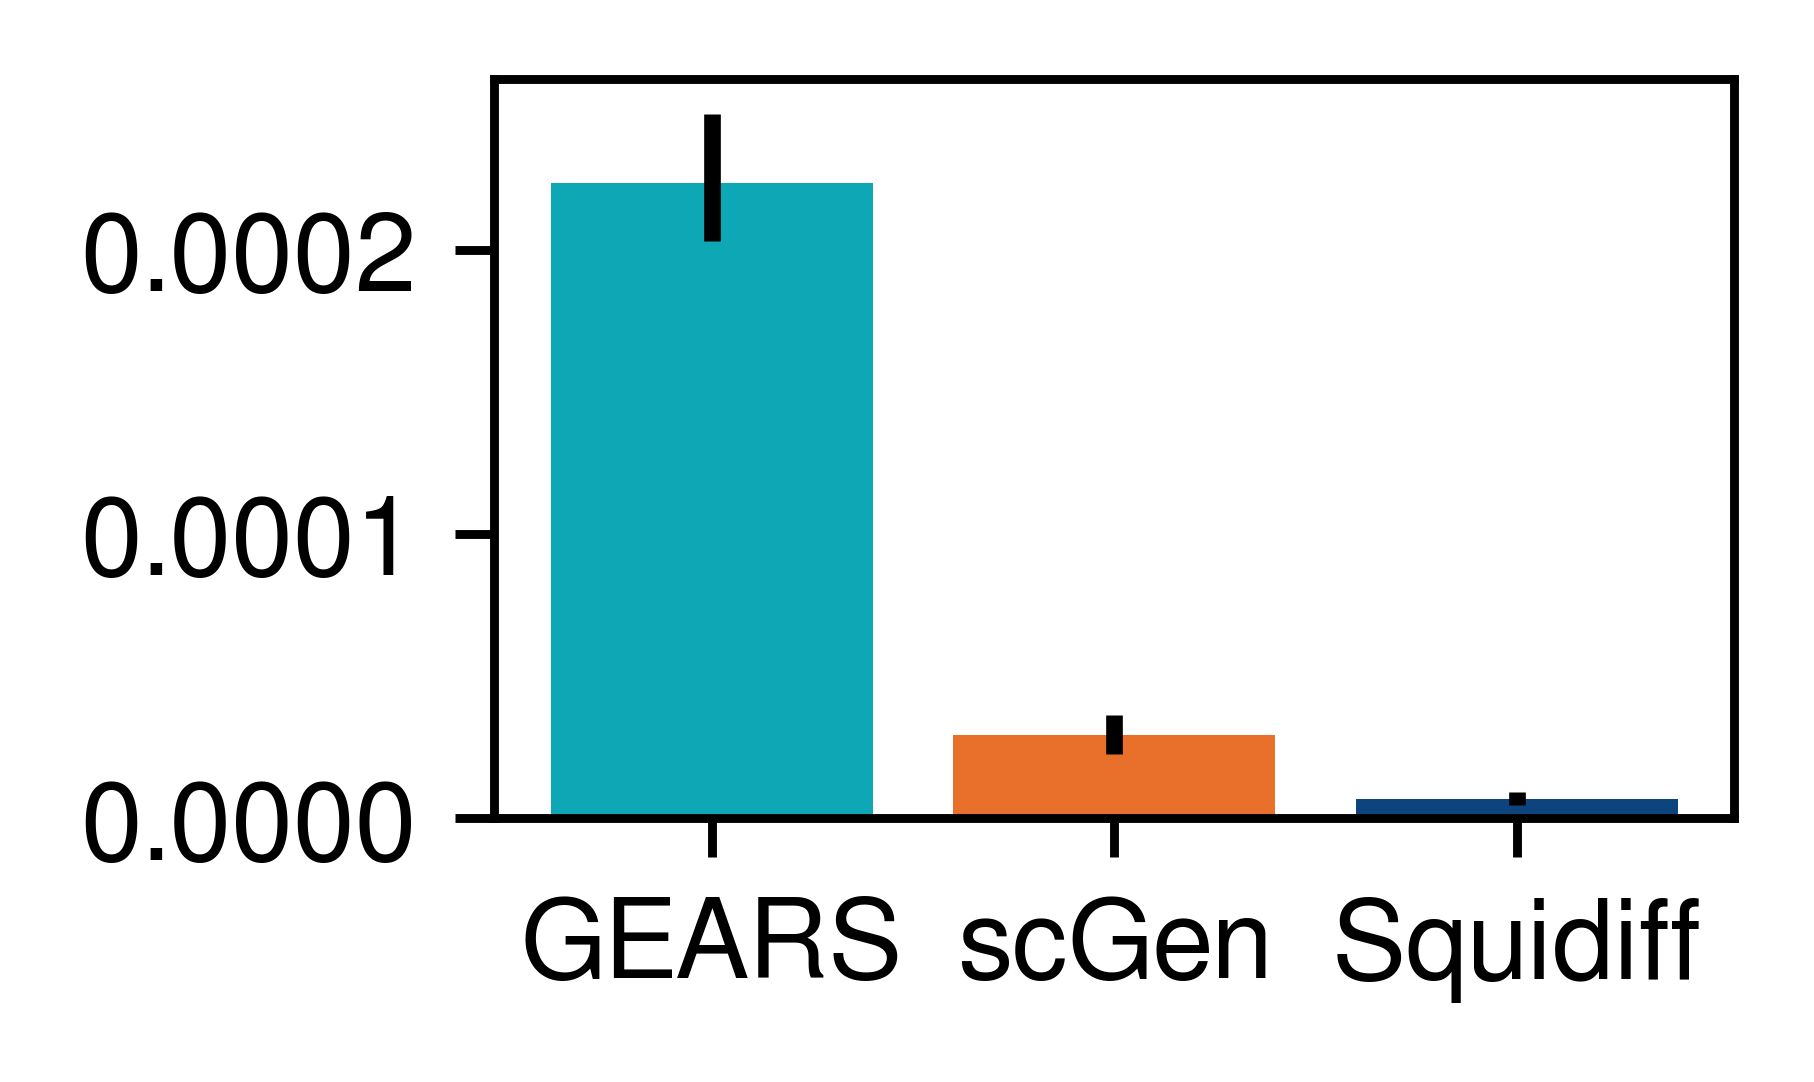

In [34]:

from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import rbf_kernel
from scipy import stats
def calculate_metrics(x, y):
    r, _ = pearsonr(x, y)
    r2 = r2_score(x, y)
    return r, r2

def calculate_mmd(x, y, gamma=0.05):
    xx = rbf_kernel(x[:, np.newaxis], x[:, np.newaxis], gamma)
    yy = rbf_kernel(y[:, np.newaxis], y[:, np.newaxis], gamma)
    xy = rbf_kernel(x[:, np.newaxis], y[:, np.newaxis], gamma)
    mmd = xx.mean() + yy.mean() - 2 * xy.mean()
    return mmd

# Bootstrap resampling
def bootstrap_metrics(adata1, adata2, n_iterations=10):
    r_values = []
    r2_values = []
    mmd_values = []

    n_cells1 = adata1.shape[0]
    n_cells2 = adata2.shape[0]

    for _ in range(n_iterations):
        indices1 = np.random.choice(n_cells1, n_cells1, replace=True)
        indices2 = np.random.choice(n_cells2, n_cells2, replace=True)
        
        x_resampled = np.mean(adata1.X[indices1], axis=0).flatten()
        y_resampled = np.array(np.mean(adata2.X[indices2], axis=0)).flatten()


        r, r2 = calculate_metrics(x_resampled, y_resampled)
        mmd = calculate_mmd(x_resampled, y_resampled)

        r_values.append(r)
        r2_values.append(r2)
        mmd_values.append(mmd)

    return np.array(r_values), np.array(r2_values), np.array(mmd_values)

# Perform bootstrapping for the datasets
r_values, r2_values, mmd_values = bootstrap_metrics(all_new_data_3, all_new_data_ctrl3)
r_values_gears, r2_values_gears, mmd_values_gears = bootstrap_metrics(all_new_data_gears3[:, all_new_data_ctrl3.var_names], all_new_data_ctrl3)
r_values_scgen, r2_values_scgen, mmd_values_scgen = bootstrap_metrics(all_new_data_scgen3, all_new_data_ctrl3)

# Calculate confidence intervals
r_ci = np.percentile(r_values, [2.5, 97.5])
r2_ci = np.percentile(r2_values, [2.5, 97.5])
mmd_ci = np.percentile(mmd_values, [2.5, 97.5])

r_ci_gears = np.percentile(r_values_gears, [2.5, 97.5])
r2_ci_gears = np.percentile(r2_values_gears, [2.5, 97.5])
mmd_ci_gears = np.percentile(mmd_values_gears, [2.5, 97.5])

r_ci_scgen = np.percentile(r_values_scgen, [2.5, 97.5])
r2_ci_scgen = np.percentile(r2_values_scgen, [2.5, 97.5])
mmd_ci_scgen = np.percentile(mmd_values_scgen, [2.5, 97.5])

# Display results
print("Pearson correlation: mean =", np.mean(r_values), ", 95% CI =", r_ci)
print("R-squared: mean =", np.mean(r2_values), ", 95% CI =", r2_ci)
print("MMD: mean =", np.mean(mmd_values), ", 95% CI =", mmd_ci)

print("Pearson correlation (GEARS): mean =", np.mean(r_values_gears), ", 95% CI =", r_ci_gears)
print("R-squared (GEARS): mean =", np.mean(r2_values_gears), ", 95% CI =", r2_ci_gears)
print("MMD (GEARS): mean =", np.mean(mmd_values_gears), ", 95% CI =", mmd_ci_gears)

print("Pearson correlation (scGen): mean =", np.mean(r_values_scgen), ", 95% CI =", r_ci_scgen)
print("R-squared (scGen): mean =", np.mean(r2_values_scgen), ", 95% CI =", r2_ci_scgen)
print("MMD (scGen): mean =", np.mean(mmd_values_scgen), ", 95% CI =", mmd_ci_scgen)

# Perform t-test
t_stat, p_value = stats.ttest_ind(r_values_gears, r_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(r_values_gears, r_values)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(r_values, r_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Perform t-test
t_stat, p_value = stats.ttest_ind(r2_values_gears, r2_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(r2_values_gears, r2_values)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(r2_values, r2_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Perform t-test
t_stat, p_value = stats.ttest_ind(mmd_values_gears, mmd_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(mmd_values_gears, mmd_values)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(mmd_values, mmd_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)


import matplotlib.pyplot as plt

# Data for plotting
metrics = ['Pearson Correlation', 'R-squared', 'MMD']
methods = [ 'GEARS', 'scGen','Squidiff']

means = [
    
    [np.mean(r_values_gears), np.mean(r2_values_gears), np.mean(mmd_values_gears)],
    [np.mean(r_values_scgen), np.mean(r2_values_scgen), np.mean(mmd_values_scgen)],
    [np.mean(r_values), np.mean(r2_values), np.mean(mmd_values)]
]

cis = [
    
    [r_ci_gears, r2_ci_gears, mmd_ci_gears],
    [r_ci_scgen, r2_ci_scgen, mmd_ci_scgen],
    [r_ci, r2_ci, mmd_ci],
]

from statannotations.Annotator import Annotator

for i, metric in enumerate(metrics):
    means_metric = [mean[i] for mean in means]
    ci_metric = [ci[i] for ci in cis]
    lower_bounds = [mean - ci[0] for mean, ci in zip(means_metric, ci_metric)]
    upper_bounds = [ci[1] - mean for mean, ci in zip(means_metric, ci_metric)]

    # Plotting
    fig, axes = plt.subplots(1, 1, figsize=(2,1.2),dpi=800)
    g1=plt.bar(methods, means_metric, yerr=[lower_bounds, upper_bounds], 
                capsize=0, 
                 color=['#0ea7b5', '#e8702a','#0c457d'])
    #plt.title(metric)
    if metric=='Pearson Correlation':
        plt.ylim([0.75,1.01])
    if metric=='R-squared':
        plt.ylim([0.5,1.01])
#plt.suptitle('Bootstrap Metrics with 95% Confidence Intervals')
plt.show()

Pearson correlation: mean = 0.9661649049124442 , 95% CI = [0.96072913 0.97188026]
R-squared: mean = 0.919644296169281 , 95% CI = [0.89578803 0.93456302]
MMD: mean = 5.638599395751953e-06 , 95% CI = [3.07559967e-06 1.19030476e-05]
Pearson correlation (GEARS): mean = 0.8069664380638246 , 95% CI = [0.79216917 0.81834432]
R-squared (GEARS): mean = 0.6084900021553039 , 95% CI = [0.58276462 0.63292668]
MMD (GEARS): mean = 0.00021076202392578125 , 95% CI = [0.00019279 0.00022673]
Pearson correlation (scGen): mean = 0.9574500539111653 , 95% CI = [0.95216211 0.96187172]
R-squared (scGen): mean = 0.6183703243732452 , 95% CI = [0.54363462 0.68403673]
MMD (scGen): mean = 3.6716461181640625e-05 , 95% CI = [2.68220901e-05 4.49240208e-05]
t-statistic: -52.652196585700864
p-value: 3.599139393847058e-21
t-statistic: -54.15800540055341
p-value: 2.173108692027387e-21
t-statistic: 5.769429503159433
p-value: 1.8133394771774116e-05
t-statistic: -0.673341193158751
p-value: 0.5092842506657977
t-statistic: -45

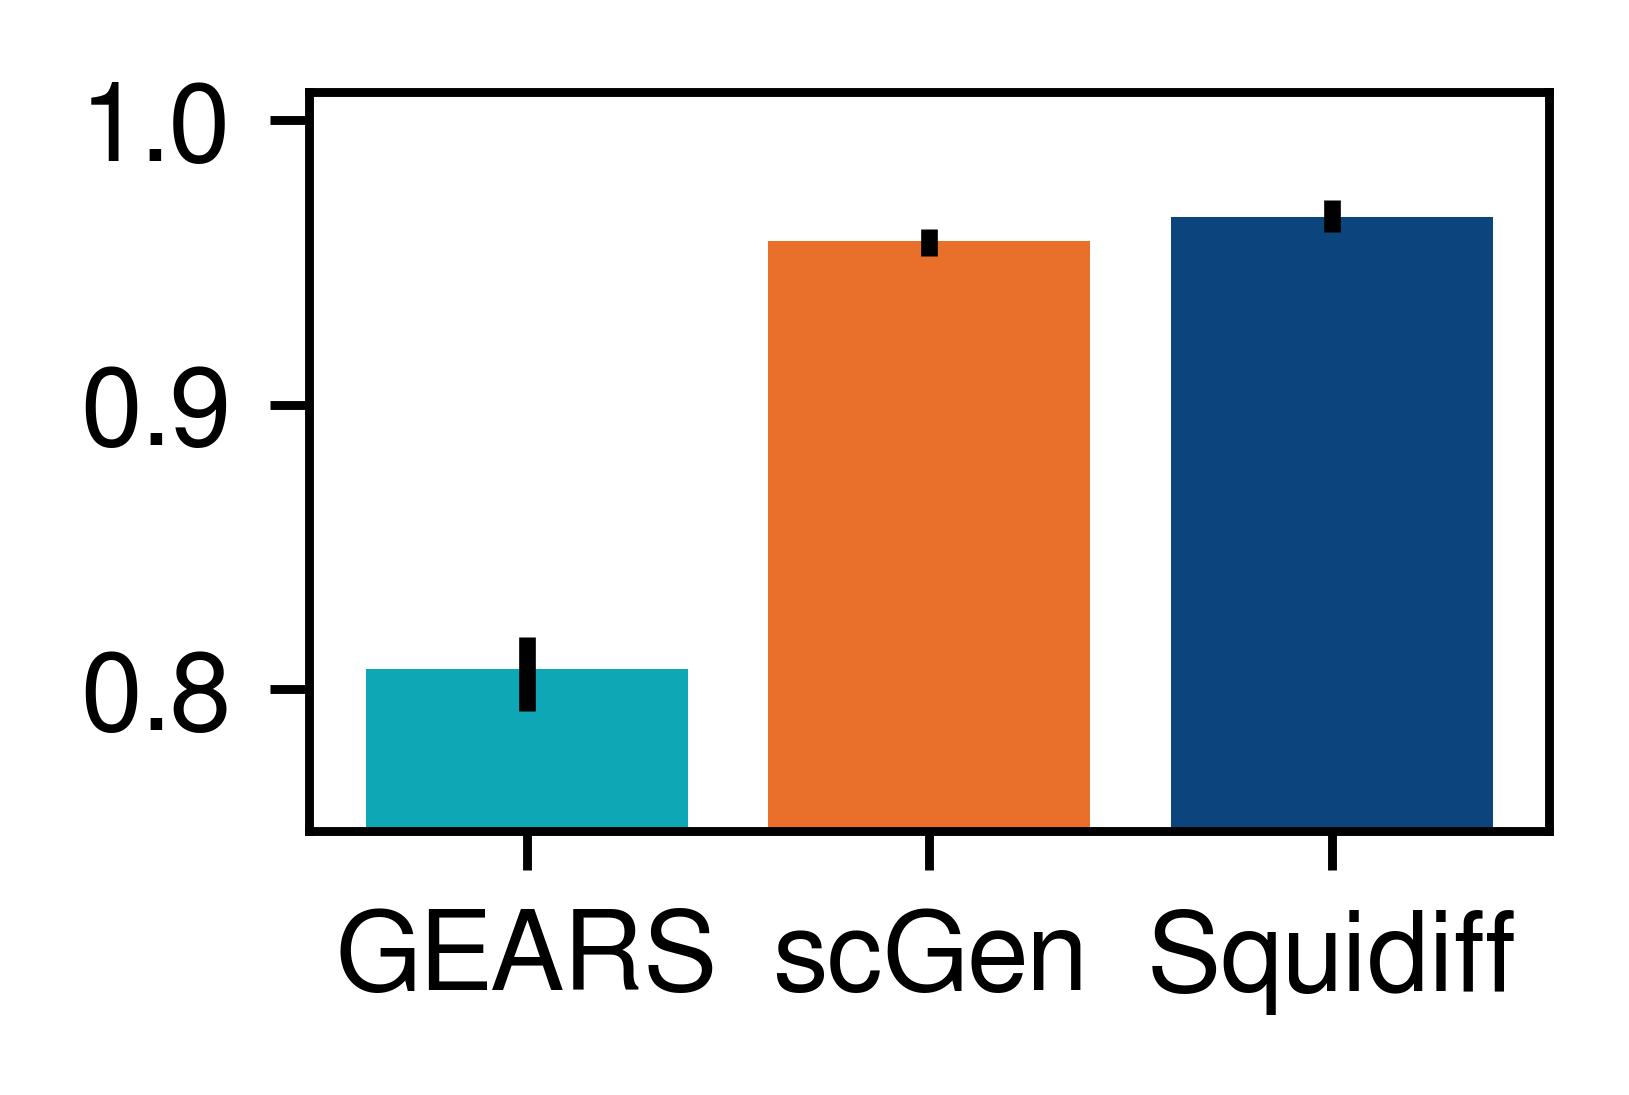

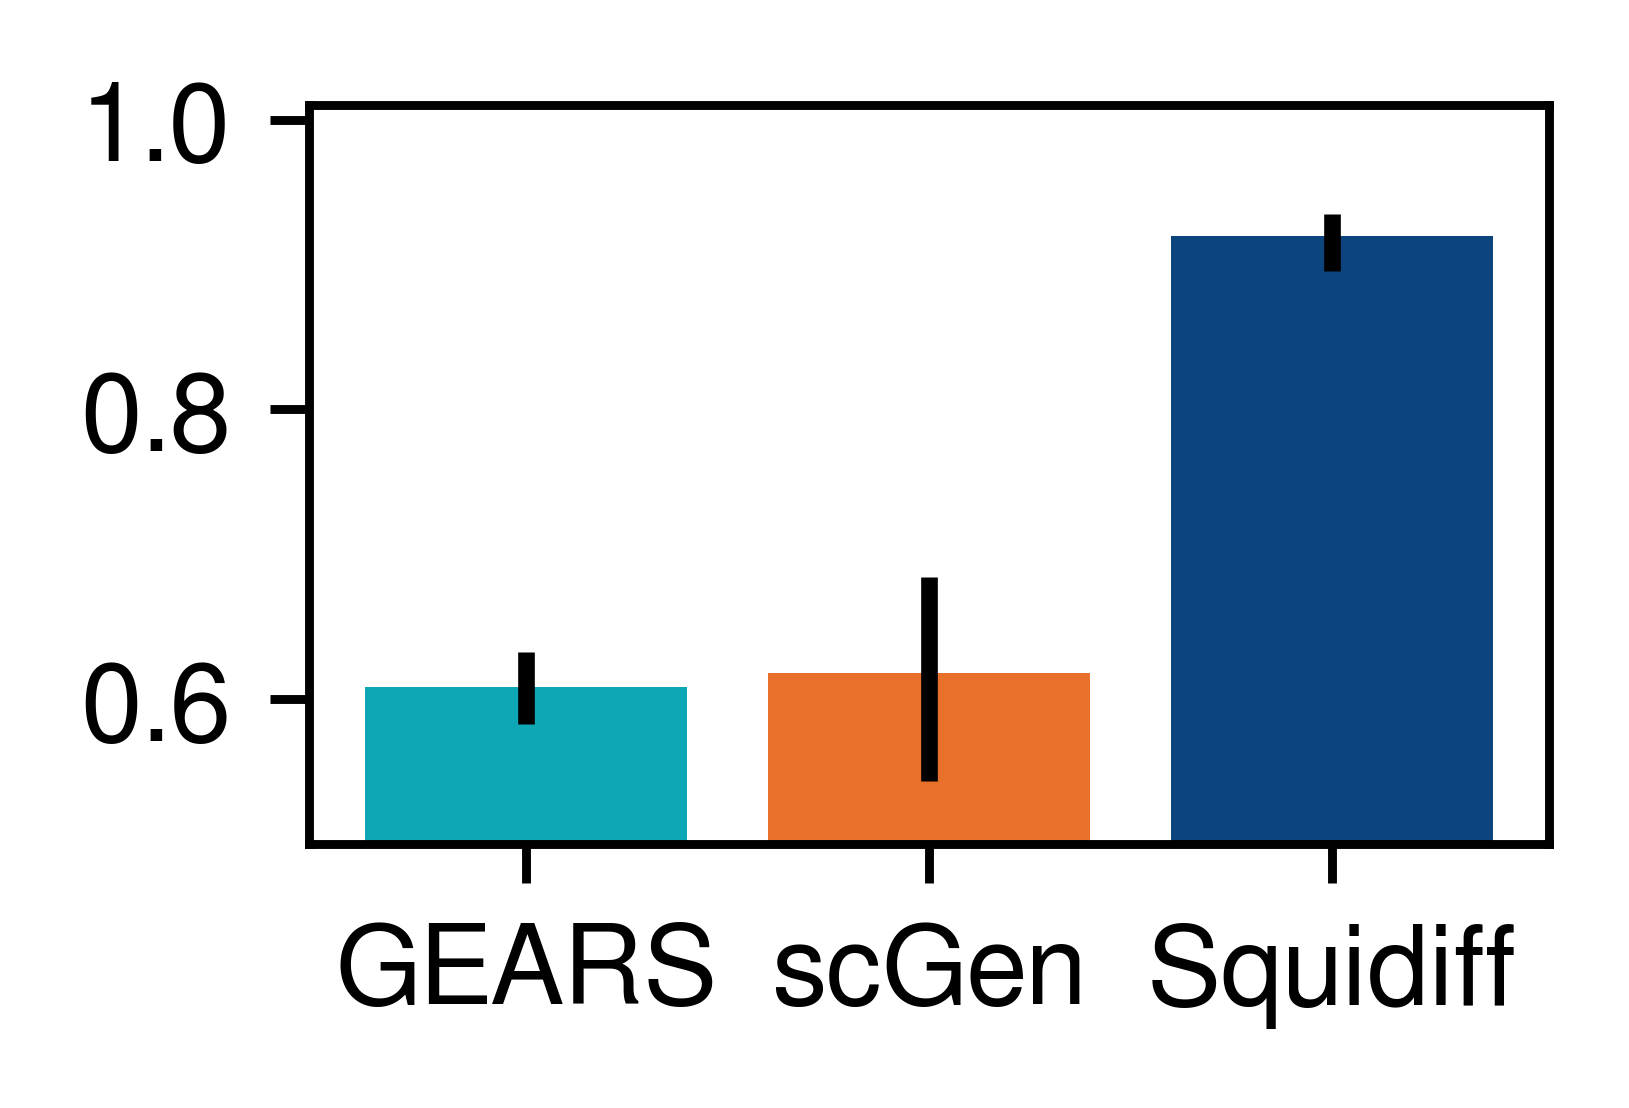

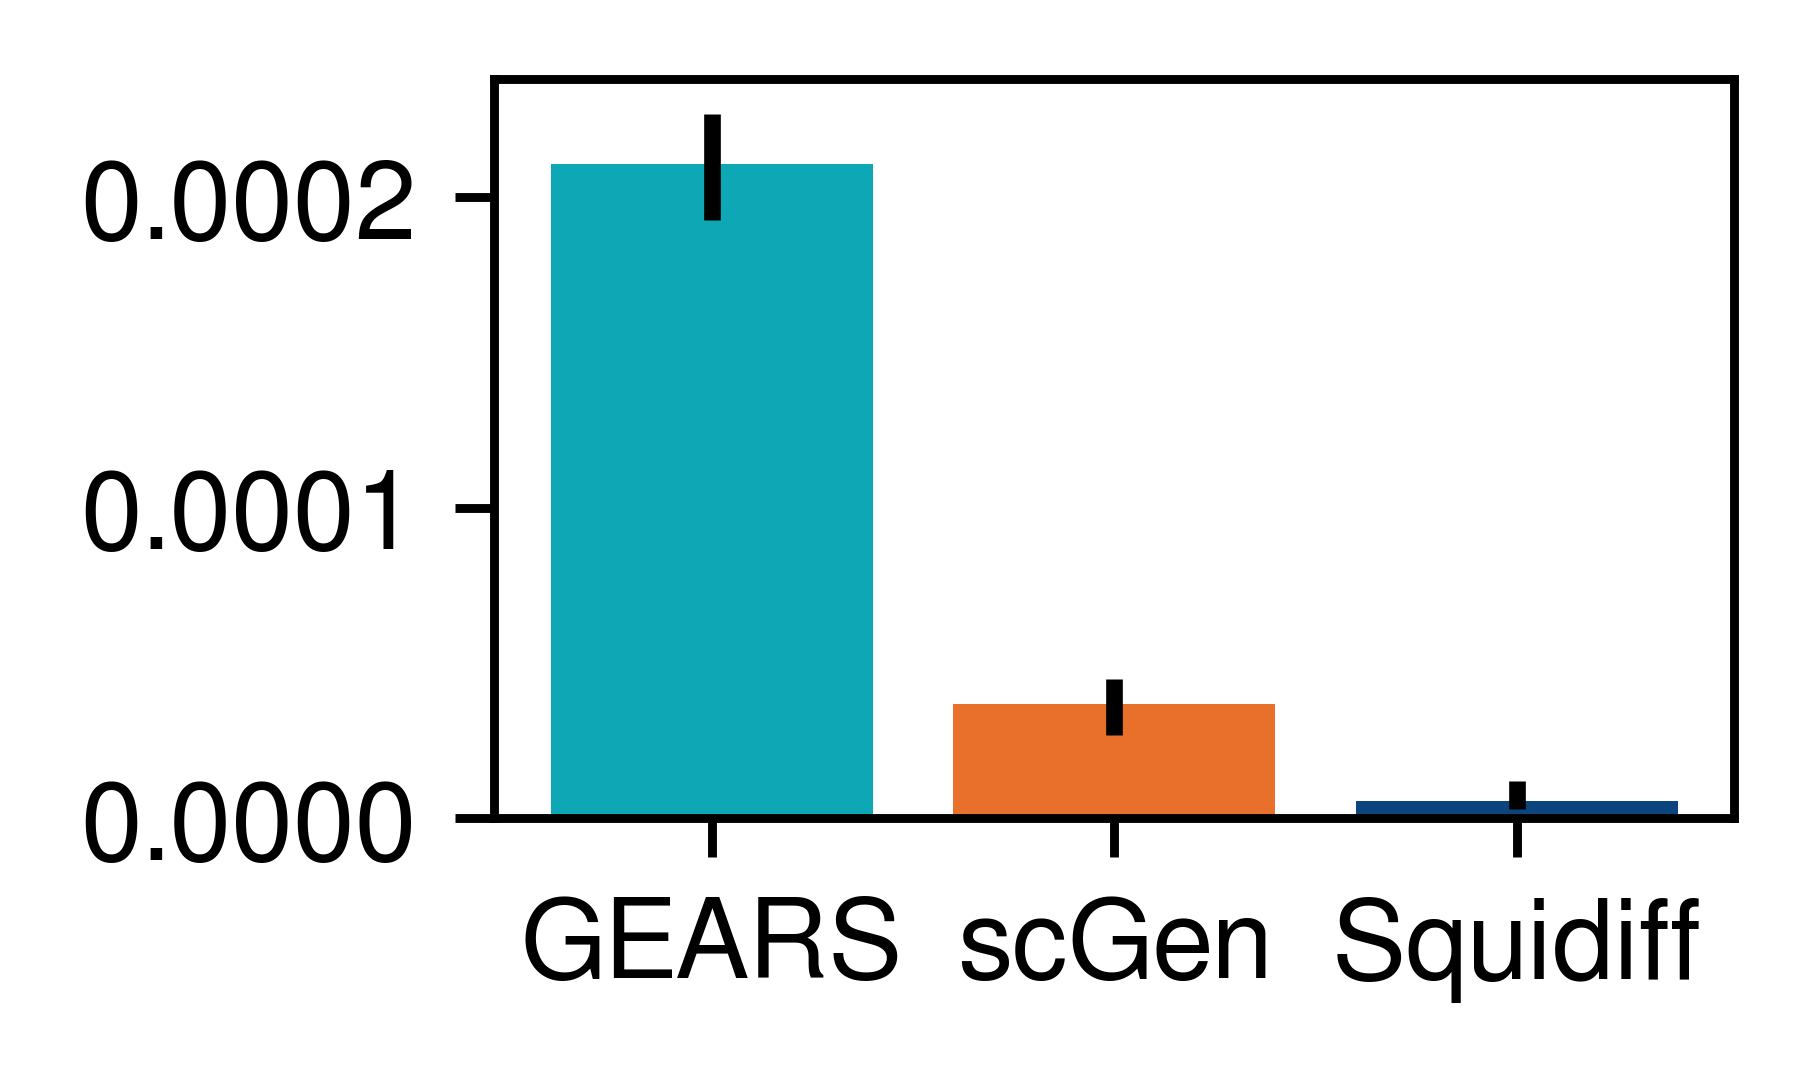

In [35]:


from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import rbf_kernel
from scipy import stats
def calculate_metrics(x, y):
    r, _ = pearsonr(x, y)
    r2 = r2_score(x, y)
    return r, r2

def calculate_mmd(x, y, gamma=0.05):
    xx = rbf_kernel(x[:, np.newaxis], x[:, np.newaxis], gamma)
    yy = rbf_kernel(y[:, np.newaxis], y[:, np.newaxis], gamma)
    xy = rbf_kernel(x[:, np.newaxis], y[:, np.newaxis], gamma)
    mmd = xx.mean() + yy.mean() - 2 * xy.mean()
    return mmd

# Bootstrap resampling
def bootstrap_metrics(adata1, adata2, adata_ctl, n_iterations=10):
    r_values = []
    r2_values = []
    mmd_values = []

    n_cells1 = adata1.shape[0]
    n_cells2 = adata2.shape[0]

    for _ in range(n_iterations):
        indices1 = np.random.choice(n_cells1, n_cells1, replace=True)
        indices2 = np.random.choice(n_cells2, n_cells2, replace=True)
        
        x_resampled = np.mean(adata1.X[indices1], axis=0).flatten()
        y_resampled = np.array(np.mean(adata2.X[indices2], axis=0)).flatten()
        ctl_resampled = np.array(np.mean(adata_ctl.X[indices2], axis=0)).flatten()

        r, r2 = calculate_metrics(x_resampled-ctl_resampled, y_resampled-ctl_resampled)
        mmd = calculate_mmd(x_resampled-ctl_resampled, y_resampled-ctl_resampled)

        r_values.append(r)
        r2_values.append(r2)
        mmd_values.append(mmd)

    return np.array(r_values), np.array(r2_values), np.array(mmd_values)

# Perform bootstrapping for the datasets
r_values, r2_values, mmd_values = bootstrap_metrics(all_new_data_3, 
                                                    all_new_data_ctrl3, 
                                                    train_adata[train_adata.obs['Group'] ==0])
r_values_gears, r2_values_gears, mmd_values_gears = bootstrap_metrics(all_new_data_gears3[:, all_new_data_ctrl3.var_names], 
                                                                      all_new_data_ctrl3,
                                                                      train_adata[train_adata.obs['Group'] ==0]
                                                                     )
r_values_scgen, r2_values_scgen, mmd_values_scgen = bootstrap_metrics(all_new_data_scgen3, all_new_data_ctrl3, train_adata[train_adata.obs['Group'] ==0])

# Calculate confidence intervals
r_ci = np.percentile(r_values, [2.5, 97.5])
r2_ci = np.percentile(r2_values, [2.5, 97.5])
mmd_ci = np.percentile(mmd_values, [2.5, 97.5])

r_ci_gears = np.percentile(r_values_gears, [2.5, 97.5])
r2_ci_gears = np.percentile(r2_values_gears, [2.5, 97.5])
mmd_ci_gears = np.percentile(mmd_values_gears, [2.5, 97.5])

r_ci_scgen = np.percentile(r_values_scgen, [2.5, 97.5])
r2_ci_scgen = np.percentile(r2_values_scgen, [2.5, 97.5])
mmd_ci_scgen = np.percentile(mmd_values_scgen, [2.5, 97.5])

# Display results
print("Pearson correlation: mean =", np.mean(r_values), ", 95% CI =", r_ci)
print("R-squared: mean =", np.mean(r2_values), ", 95% CI =", r2_ci)
print("MMD: mean =", np.mean(mmd_values), ", 95% CI =", mmd_ci)

print("Pearson correlation (GEARS): mean =", np.mean(r_values_gears), ", 95% CI =", r_ci_gears)
print("R-squared (GEARS): mean =", np.mean(r2_values_gears), ", 95% CI =", r2_ci_gears)
print("MMD (GEARS): mean =", np.mean(mmd_values_gears), ", 95% CI =", mmd_ci_gears)

print("Pearson correlation (scGen): mean =", np.mean(r_values_scgen), ", 95% CI =", r_ci_scgen)
print("R-squared (scGen): mean =", np.mean(r2_values_scgen), ", 95% CI =", r2_ci_scgen)
print("MMD (scGen): mean =", np.mean(mmd_values_scgen), ", 95% CI =", mmd_ci_scgen)

# Perform t-test
t_stat, p_value = stats.ttest_ind(r_values_gears, r_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(r_values_gears, r_values)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(r_values, r_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Perform t-test
t_stat, p_value = stats.ttest_ind(r2_values_gears, r2_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(r2_values_gears, r2_values)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(r2_values, r2_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Perform t-test
t_stat, p_value = stats.ttest_ind(mmd_values_gears, mmd_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(mmd_values_gears, mmd_values)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(mmd_values, mmd_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)


import matplotlib.pyplot as plt

# Data for plotting
metrics = ['Pearson Correlation', 'R-squared', 'MMD']
methods = [ 'GEARS', 'scGen','Squidiff']

means = [
    
    [np.mean(r_values_gears), np.mean(r2_values_gears), np.mean(mmd_values_gears)],
    [np.mean(r_values_scgen), np.mean(r2_values_scgen), np.mean(mmd_values_scgen)],
    [np.mean(r_values), np.mean(r2_values), np.mean(mmd_values)]
]

cis = [
    
    [r_ci_gears, r2_ci_gears, mmd_ci_gears],
    [r_ci_scgen, r2_ci_scgen, mmd_ci_scgen],
    [r_ci, r2_ci, mmd_ci],
]

from statannotations.Annotator import Annotator

for i, metric in enumerate(metrics):
    means_metric = [mean[i] for mean in means]
    ci_metric = [ci[i] for ci in cis]
    lower_bounds = [mean - ci[0] for mean, ci in zip(means_metric, ci_metric)]
    upper_bounds = [ci[1] - mean for mean, ci in zip(means_metric, ci_metric)]

    # Plotting
    fig, axes = plt.subplots(1, 1, figsize=(2,1.2),dpi=800)
    g1=plt.bar(methods, means_metric, yerr=[lower_bounds, upper_bounds], 
                capsize=0, 
                 color=['#0ea7b5', '#e8702a','#0c457d'])
    #plt.title(metric)
    if metric=='Pearson Correlation':
        plt.ylim([0.75,1.01])
    if metric=='R-squared':
        plt.ylim([0.5,1.01])
#plt.suptitle('Bootstrap Metrics with 95% Confidence Intervals')
plt.show()

t-statistic: 12.598800379098256
p-value: 2.2952699004187218e-10
t-statistic: 17.372085568073825
p-value: 1.0795553457965147e-12
t-statistic: -4.21497897329964
p-value: 0.0005206065466763477


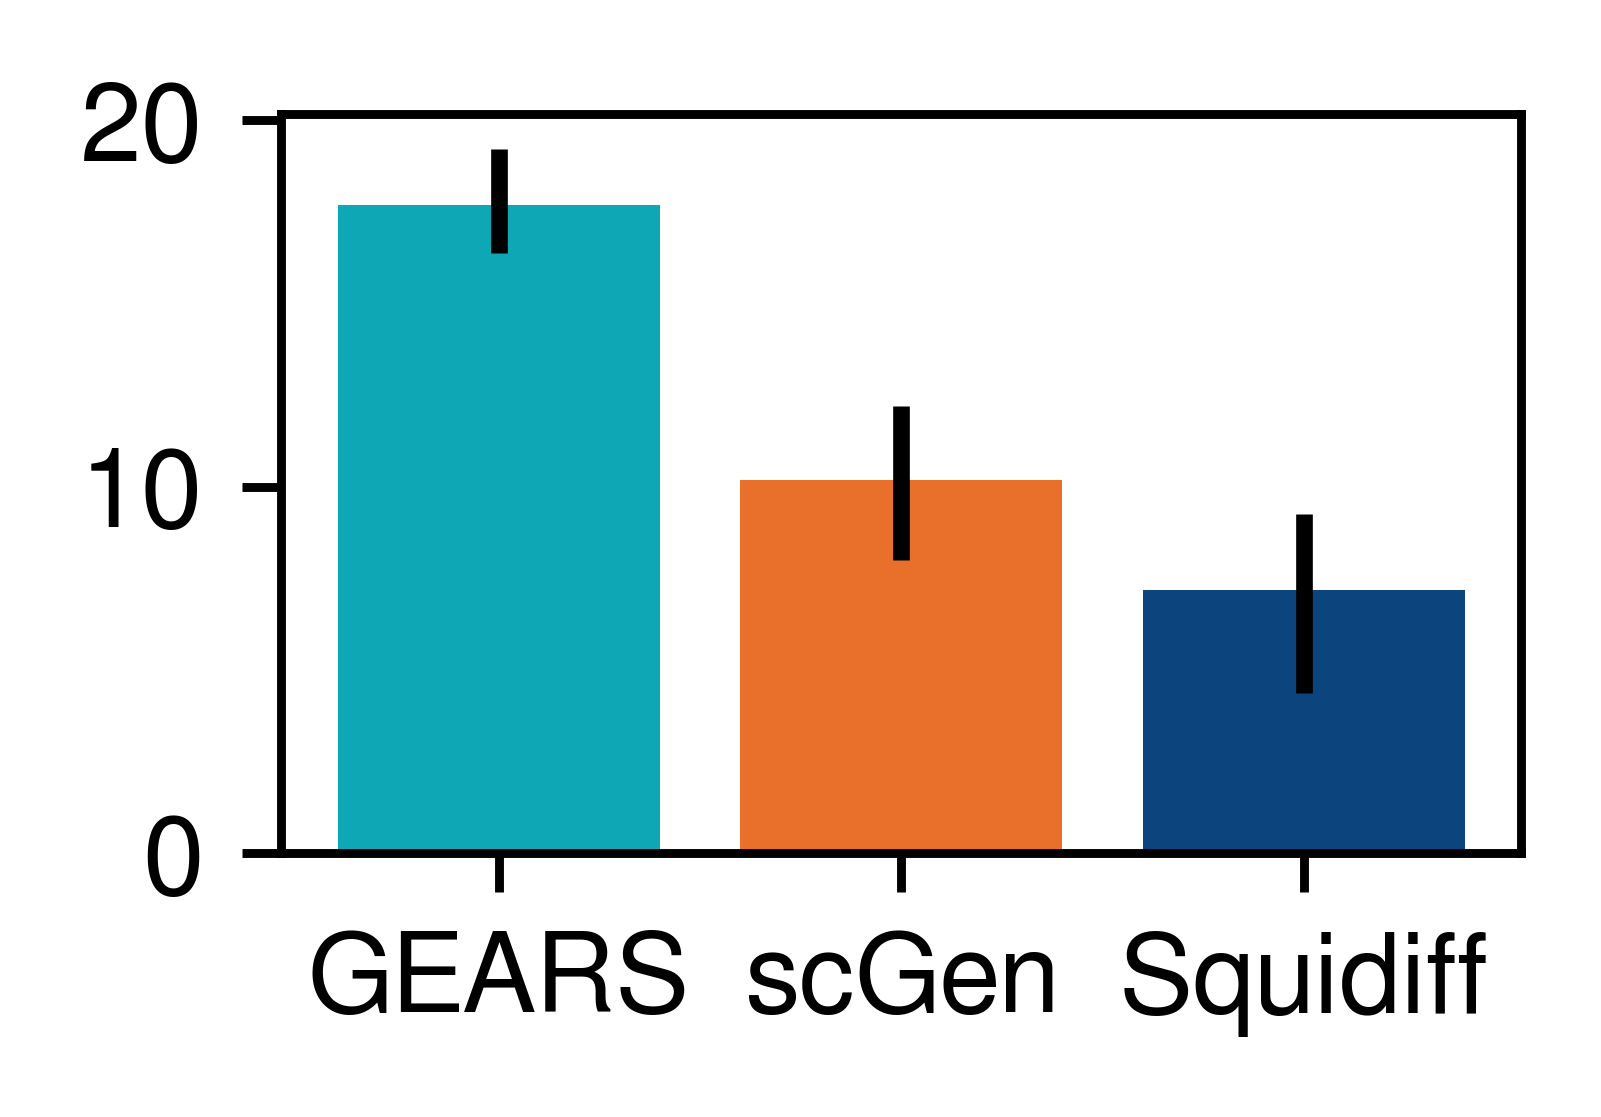

In [36]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import rbf_kernel
from scipy import stats
import numpy as np

def calculate_overlap(x, y):
    """
    Quickly calculates the percentage and proportion of (x, y) pairs with opposite signs using NumPy.
    
    Args:
        x (list or numpy array): Numerical values.
        y (list or numpy array): Numerical values (same length as x).
    
    Returns:
        r (float): Percentage of pairs where x and y have opposite signs.
        r2 (float): Proportion (decimal form) of such cases.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Opposite signs occur when x and y have different signs
    opposite_signs_mask = (x > 0) & (y < 0) | (x < 0) & (y > 0)
    
    opposite_signs_count = np.count_nonzero(opposite_signs_mask)
    total_pairs = x.size  # Faster than len(x)

    r2 = opposite_signs_count / total_pairs  # Proportion
    r = r2 * 100  # Percentage
    
    return r


# Bootstrap resampling
def bootstrap_metrics(adata1, adata2, adata_ctl, n_iterations=10):
    r_values = []


    n_cells1 = adata1.shape[0]
    n_cells2 = adata2.shape[0]

    for _ in range(n_iterations):
        indices1 = np.random.choice(n_cells1, n_cells1, replace=True)
        indices2 = np.random.choice(n_cells2, n_cells2, replace=True)
        
        x_resampled = np.mean(adata1.X[indices1], axis=0).flatten()
        y_resampled = np.array(np.mean(adata2.X[indices2], axis=0)).flatten()
        ctl_resampled = np.array(np.mean(adata_ctl.X[indices2], axis=0)).flatten()

        r_value = calculate_overlap(x_resampled-ctl_resampled, y_resampled-ctl_resampled)
        

        r_values.append(r_value)

    return np.array(r_values)

# Perform bootstrapping for the datasets
r_values = bootstrap_metrics(all_new_data_3, 
                                                    all_new_data_ctrl3, 
                                                    train_adata[train_adata.obs['Group'] ==0])
r_values_gears= bootstrap_metrics(all_new_data_gears3[:, all_new_data_ctrl3.var_names], 
                                                                      all_new_data_ctrl3,
                                                                      train_adata[train_adata.obs['Group'] ==0]
                                                                     )
r_values_scgen = bootstrap_metrics(all_new_data_scgen3, all_new_data_ctrl3, train_adata[train_adata.obs['Group'] ==0])

# Perform t-test
t_stat, p_value = stats.ttest_ind(r_values_gears, r_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(r_values_gears, r_values)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(r_values, r_values_scgen)
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Calculate confidence intervals
r_ci = np.percentile(r_values, [2.5, 97.5])
r_ci_gears = np.percentile(r_values_gears, [2.5, 97.5])

r_ci_scgen = np.percentile(r_values_scgen, [2.5, 97.5])

import matplotlib.pyplot as plt

# Data for plotting
metrics = ['Pearson Correlation', 'R-squared', 'MMD']
methods = [ 'GEARS', 'scGen','Squidiff']
means = [
    
    [np.mean(r_values_gears)],
    [np.mean(r_values_scgen)],
    [np.mean(r_values)]
]

cis = [
    
    [r_ci_gears],
    [r_ci_scgen],
    [r_ci],
]


from statannotations.Annotator import Annotator

for i, metric in enumerate(['Pearson Correlation']):
    means_metric = [mean[i] for mean in means]
    ci_metric = [ci[i] for ci in cis]
    lower_bounds = [mean - ci[0] for mean, ci in zip(means_metric, ci_metric)]
    upper_bounds = [ci[1] - mean for mean, ci in zip(means_metric, ci_metric)]

    # Plotting
    fig, axes = plt.subplots(1, 1, figsize=(2,1.2),dpi=800)
    g1=plt.bar(methods, means_metric, yerr=[lower_bounds, upper_bounds], 
                capsize=0, 
                 color=['#0ea7b5', '#e8702a','#0c457d'])
    #plt.title(metric)
    #if metric=='Pearson Correlation':
        #plt.ylim([0.75,1.01])
    #if metric=='R-squared':
    #    plt.ylim([0.5,1.01])
#plt.suptitle('Bootstrap Metrics with 95% Confidence Intervals')
plt.show()